Spring 2021
<img src="https://www.cuipcairo.org/sites/default/files/styles/medium/public/49658177_2020840098011471_2893445443553853440_n.png?itok=672tzxcF"
 width="80px" align="right">

CIE 555, Neural Networks and Deep Learning

University of Science and Technology, Zewail City

<br>

<h1 align="center">Lab 7 Solution template</h3>
<h1 align="center">Convolutional Neural Networks: Part II</h3>

---

Lab Partner: Hazem Tarek 201-800-283

# task 1: download, and explore the dataset:




download from google drive ([here](https://drive.google.com/file/d/1LDI2VBt8oORN__TXzVdHLGwdztP8RopK/view?usp=sharing)).   

In [ ]:
# Reuse the code from the lab file, get the file ID from the url 
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1LDI2VBt8oORN__TXzVdHLGwdztP8RopK'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('archive.zip')

unzip the file into an appropriately named folder.


In [ ]:
!mkdir /content/Fruit_and_Vegetables 
!unzip -q /content/archive.zip -d /content/Fruit_and_Vegetables

 load some image paths from the dataset folder

In [ ]:
import os
import random 
from glob import glob
from pathlib import Path
DATASET_DIR = os.path.join("/content", "Fruit_and_Vegetables")
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
TEST_DIR = os.path.join(DATASET_DIR, "test")

all_data = [y for x in os.walk(DATASET_DIR) for y in glob(os.path.join(x[0], '*jpg'))]
all_labels = [os.path.basename(os.path.dirname(x)) for x in all_data]
print(len(all_data))
all_data[:10]

17900


['/content/Fruit_and_Vegetables/test/Papaya/15.jpg',
 '/content/Fruit_and_Vegetables/test/Papaya/16.jpg',
 '/content/Fruit_and_Vegetables/test/Papaya/11.jpg',
 '/content/Fruit_and_Vegetables/test/Papaya/17.jpg',
 '/content/Fruit_and_Vegetables/test/Papaya/40.jpg',
 '/content/Fruit_and_Vegetables/test/Papaya/1.jpg',
 '/content/Fruit_and_Vegetables/test/Papaya/26.jpg',
 '/content/Fruit_and_Vegetables/test/Papaya/10.jpg',
 '/content/Fruit_and_Vegetables/test/Papaya/7.jpg',
 '/content/Fruit_and_Vegetables/test/Papaya/8.jpg']

count the classes and print their names.

In [ ]:
#find unique classes
unique = [x for i, x in enumerate(all_labels) if i == all_labels.index(x)]
print(f"There are {len(unique)} unique classes.\n")
unique

There are 30 unique classes.



['Papaya',
 'Broccoli',
 'Dragon',
 'Cauliflower',
 'Cucumber',
 'Carrots',
 'Dates',
 'Pomegranate',
 'Apple',
 'Mango',
 'Jackfruit',
 'Strawberry',
 'Grape',
 'Kiwi',
 'Peanut',
 'Coconut',
 'Okra',
 'Watermelon',
 'Pineapple',
 'Green Lemon',
 'Orange',
 'Egg',
 'Chili',
 'Custard apple',
 'Onion',
 'Sweet Potato',
 'Star Fruit',
 'White Mushroom',
 'Garlic',
 'Banana']

 view 25 random samples and their labels from the dataset

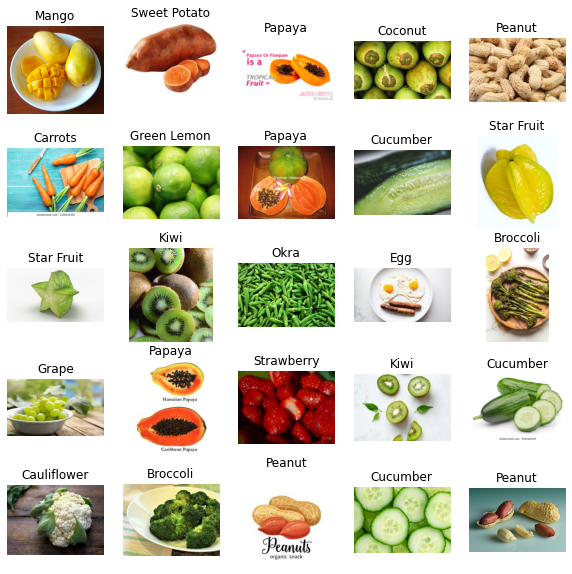

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Sample 25 images from dataset
indices = np.random.randint(0, len(all_data), size=25)
images = [all_data[i] for i in indices]
labels = [all_labels[i] for i in indices]

# Plot the 25 images
plt.figure(figsize=(10,10))
for i in range(len(indices)):
    plt.subplot(5, 5, i + 1)
    image = mpimg.imread(images[i]) # Read image from disk
    plt.imshow(image)
    plt.title(labels[i])
    plt.axis('off')
    
plt.show()

#task 2: Load and Pre-process the images

To load the dataset and prepare it for the model,  use the previously introduced `ImageDataGenerator` class provided by Keras.  

**We used ResNet50 preprocessing function for our base model.**

In [ ]:
## define train test and validation generators 
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

BATCH_SIZE = 64
HEIGHT = 200
WIDTH = 200
VAL_SPLIT = 0.2

# 1. Construct an instance of the `ImageDataGenerator` class
train_datagen =  ImageDataGenerator(
      preprocessing_function = tf.keras.applications.resnet50.preprocess_input,
      width_shift_range=0.1,
      height_shift_range=0.1,
      rotation_range=20,
      validation_split = VAL_SPLIT
    )

# 2. Retrieve the iterator
train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 11992 images belonging to 30 classes.


In [ ]:
val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    shuffle = True,
    seed = 7,
    color_mode='rgb',
    class_mode='categorical',
    subset='validation')

Found 2991 images belonging to 30 classes.


In [ ]:
# Do the same steps for the test set

# 1. Construct an instance of the `ImageDataGenerator` class
test_datagen =  ImageDataGenerator(
    preprocessing_function = tf.keras.applications.resnet50.preprocess_input
    )

# 2. Retrieve the iterator
test_generator = test_datagen.flow_from_directory(TEST_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical')

Found 1496 images belonging to 30 classes.


# task 3: define and compile your model:



**We Used ResNet50 Architeture.**

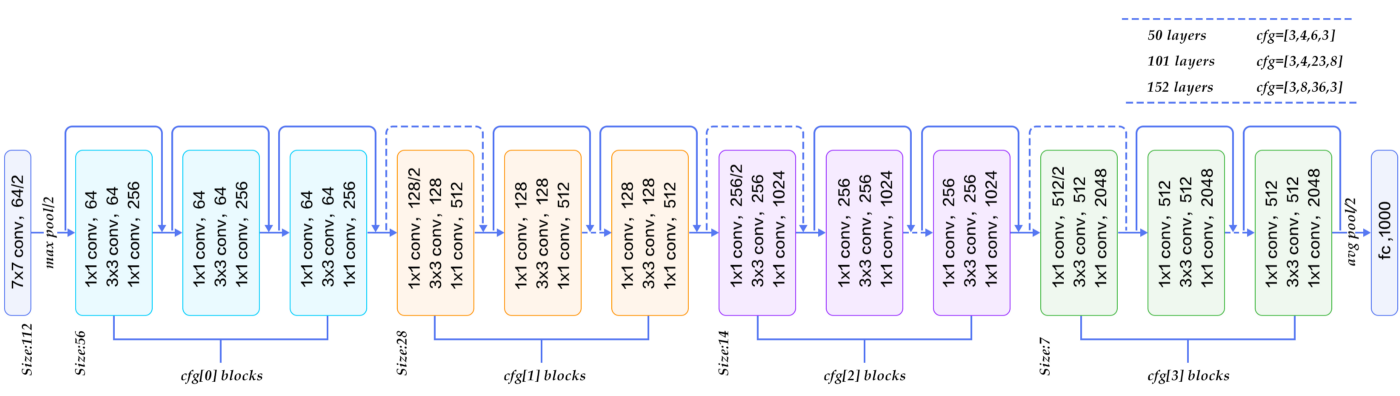

* Firstly, we used the base model without the top layer and set their trainable attributes to false .
* Secondly, we added our top layer and start training the output layers using the pretrained weights of ImageNet.

* We then tried to fine-tune the model by training some of the base model's layers.

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout

# Load model without classification head
base_model = ResNet50(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

# Print base model summary
base_model.summary()


94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
# Mark loaded layers as not trainable
for layer in base_model.layers:
  layer.trainable = False


# Add new classifier layers
x = Flatten()(base_model.layers[-1].output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
output = Dense(30, activation='softmax')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)

# Print summary
model.summary()

# Compile
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = base_learning_rate),
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

# task 4:  Train your model

start the training loop

In [ ]:
import tensorflow as tf

INITIAL_EPOCHS = 10

history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs = INITIAL_EPOCHS)

Epoch 1/10
 22/188 [==>...........................] - ETA: 5:15 - loss: 3.3612 - accuracy: 0.2678

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


167/188 [=========================>....] - ETA: 38s - loss: 1.5589 - accuracy: 0.6162

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


188/188 [==============================] - ETA: 0s - loss: 1.4872 - accuracy: 0.6327

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


188/188 [==============================] - 452s 2s/step - loss: 1.4872 - accuracy: 0.6327 - val_loss: 0.5579 - val_accuracy: 0.8542
Epoch 2/10
188/188 [==============================] - 435s 2s/step - loss: 0.6765 - accuracy: 0.8286 - val_loss: 0.4719 - val_accuracy: 0.8730
Epoch 3/10
188/188 [==============================] - 432s 2s/step - loss: 0.5128 - accuracy: 0.8685 - val_loss: 0.5570 - val_accuracy: 0.8833
Epoch 4/10
188/188 [==============================] - 428s 2s/step - loss: 0.4070 - accuracy: 0.8972 - val_loss: 0.4345 - val_accuracy: 0.9061
Epoch 5/10
188/188 [==============================] - 428s 2s/step - loss: 0.3486 - accuracy: 0.9134 - val_loss: 0.4927 - val_accuracy: 0.9050
Epoch 6/10
188/188 [==============================] - 426s 2s/step - loss: 0.3175 - accuracy: 0.9222 - val_loss: 0.5078 - val_accuracy: 0.9064
Epoch 7/10
188/188 [==============================] - 431s 2s/step - loss: 0.2964 - accuracy: 0.9294 - val_loss: 0.4843 - val_accuracy: 0.9134
Epoch 8/10

plot the Learning curves


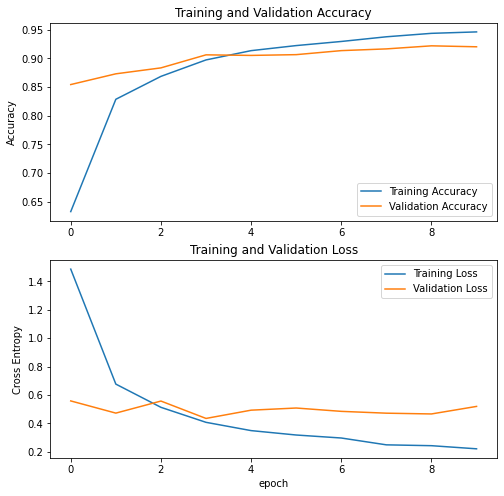

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**The model reaches training accuracy of 94% and validation accuracy of 92%.**

Fine-Tuning: This step is optional, if you reach an acceptable accuracy on your first run you can safely ignore it. 

In [ ]:
for i, layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable)


0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

* We choose to trian the layers of block 3 starting from layer 165.

In [ ]:
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 165

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


Number of layers in the base model:  175


In [ ]:
for i, layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = base_learning_rate/10),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

for i, layer in enumerate(model.layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

## Continue Training

In [ ]:
FINE_TUNE_EPOCHS = 5
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

history_fine = model.fit(train_generator,
                        validation_data = val_generator,
                        initial_epoch=history.epoch[-1], # specify the initial value of epoch to start from when training
                        epochs = TOTAL_EPOCHS)


Epoch 10/15
  7/188 [>.............................] - ETA: 5:01 - loss: 0.1877 - accuracy: 0.9487

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


181/188 [===========================>..] - ETA: 12s - loss: 0.1530 - accuracy: 0.9648

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


188/188 [==============================] - ETA: 0s - loss: 0.1532 - accuracy: 0.9651

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


188/188 [==============================] - 470s 2s/step - loss: 0.1532 - accuracy: 0.9651 - val_loss: 0.4944 - val_accuracy: 0.9241
Epoch 11/15
188/188 [==============================] - 440s 2s/step - loss: 0.1070 - accuracy: 0.9737 - val_loss: 0.4926 - val_accuracy: 0.9285
Epoch 12/15
188/188 [==============================] - 446s 2s/step - loss: 0.0744 - accuracy: 0.9799 - val_loss: 0.5002 - val_accuracy: 0.9305
Epoch 13/15
188/188 [==============================] - 452s 2s/step - loss: 0.0682 - accuracy: 0.9808 - val_loss: 0.5400 - val_accuracy: 0.9258
Epoch 14/15
188/188 [==============================] - 453s 2s/step - loss: 0.0615 - accuracy: 0.9830 - val_loss: 0.4790 - val_accuracy: 0.9348
Epoch 15/15
188/188 [==============================] - 464s 2s/step - loss: 0.0495 - accuracy: 0.9866 - val_loss: 0.4691 - val_accuracy: 0.9315


### Learning Curves

We will append the new curves to the old ones so we can visualize the effect of fine-tuning on the graph.

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

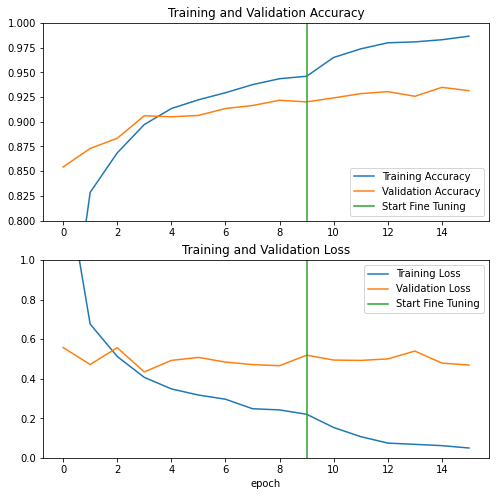

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([INITIAL_EPOCHS-1,INITIAL_EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([INITIAL_EPOCHS-1,INITIAL_EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Task 5: Evaluate your model

evaluate on the test set 

In [ ]:
model.evaluate(test_generator)

 4/24 [====>.........................] - ETA: 29s - loss: 0.0256 - accuracy: 0.9922

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 5/24 [=====>........................] - ETA: 26s - loss: 0.0205 - accuracy: 0.9937

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


24/24 [==============================] - 30s 1s/step - loss: 0.0627 - accuracy: 0.9893


[0.06272291392087936, 0.9893048405647278]

Display the confusion matrix, preferably visualize it using matplotlib. check out  `plt.matshow`.

Set test generator shuffle to false

In [ ]:
# Do the same steps for the test set

# 1. Construct an instance of the `ImageDataGenerator` class
test_datagen =  ImageDataGenerator(
    preprocessing_function = tf.keras.applications.resnet50.preprocess_input
    )

# 2. Retrieve the iterator
test_generator = test_datagen.flow_from_directory(TEST_DIR, 
                                                  shuffle = False,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical')

Found 1496 images belonging to 30 classes.


In [ ]:
import itertools    

def plot_confusion_matrix(cm, class_names):    
    figure = plt.figure(figsize=(30, 30))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

In [ ]:
test_pred_raw = model.predict(test_generator)
test_pred = np.argmax(test_pred_raw, axis=1)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


In [ ]:
test_pred

array([ 0,  0,  0, ..., 29, 29, 29])

In [ ]:
test_generator.labels

array([ 0,  0,  0, ..., 29, 29, 29], dtype=int32)

In [ ]:
test_generator.class_indices

{'Apple': 0,
 'Banana': 1,
 'Broccoli': 2,
 'Carrots': 3,
 'Cauliflower': 4,
 'Chili': 5,
 'Coconut': 6,
 'Cucumber': 7,
 'Custard apple': 8,
 'Dates': 9,
 'Dragon': 10,
 'Egg': 11,
 'Garlic': 12,
 'Grape': 13,
 'Green Lemon': 14,
 'Jackfruit': 15,
 'Kiwi': 16,
 'Mango': 17,
 'Okra': 18,
 'Onion': 19,
 'Orange': 20,
 'Papaya': 21,
 'Peanut': 22,
 'Pineapple': 23,
 'Pomegranate': 24,
 'Star Fruit': 25,
 'Strawberry': 26,
 'Sweet Potato': 27,
 'Watermelon': 28,
 'White Mushroom': 29}

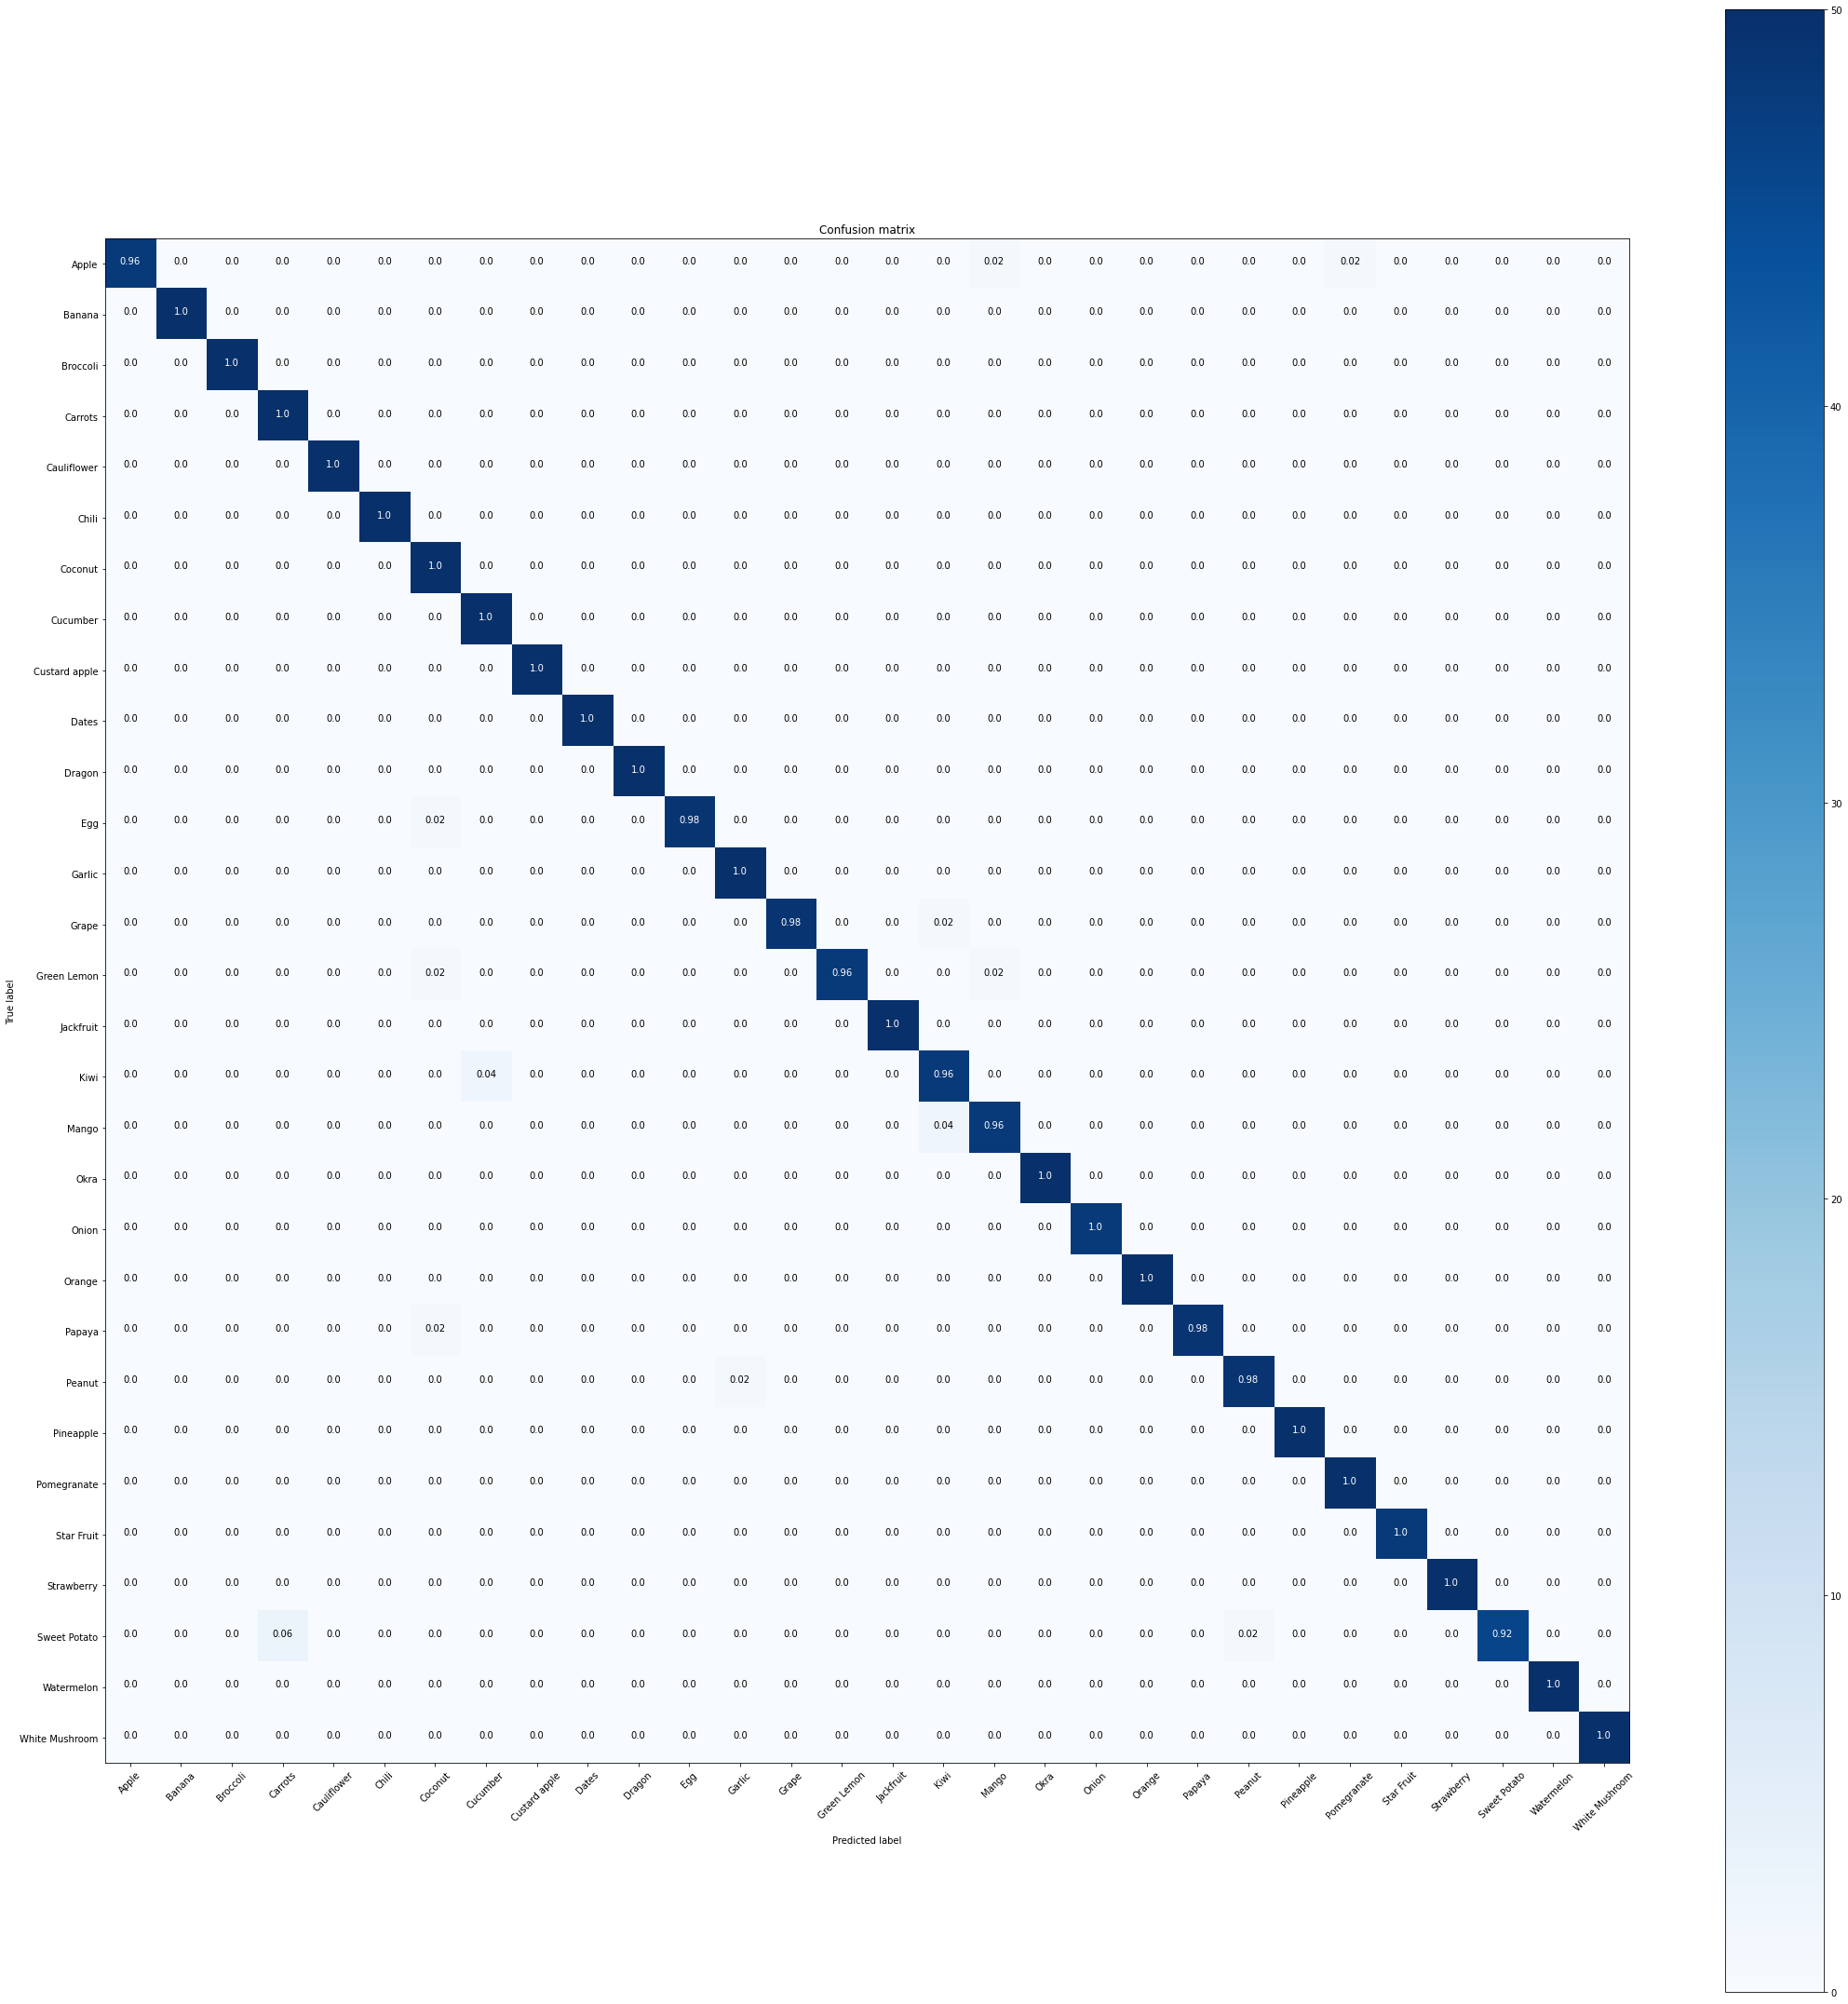

In [ ]:
import sklearn.metrics
# Calculate the confusion matrix using sklearn.metrics
cm = sklearn.metrics.confusion_matrix(test_generator.labels, test_pred)
figure = plot_confusion_matrix(cm, class_names=test_generator.class_indices)

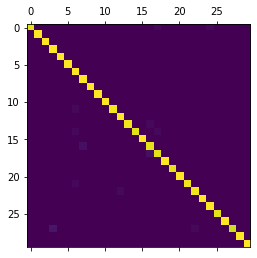

In [ ]:
plt.matshow(cm,30)